# Unveiling Character Dynamics: A Quantitative Exploration of Movie Narratives

Welcome to our project notebook for Milestone P2! 

Throughout this phase, our team has dedicated efforts to enhance our project proposal and initiate initial examinations, laying the groundwork for an effective expedition into data exploration and analysis.

## Table of Contents
- [Section I: Exploratory Data Analysis✅](#section-i-exploratory-data-analysis)
- [Section II: Generation of Character Networks🏗️](#)
- [Section III: Persona Extraction and Mapping🚧](#)
- [Setion IV: Main and Side Character Analysis🚧](#)
- [Section V: Network Dynamics Analysis🚧](#)

In [2]:
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from helper import *

%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

ModuleNotFoundError: No module named 'plotly'

## Section I: Exploratory Data Analysis

The movie metadata set includes movie box office revenue, genre, release date, runtime, and language. We did some exploratory analysis to better understand the movie distribution, providing us the neccessary context of those movies.

In [4]:
# Load Data
movies = pd.read_csv('../data/movie.metadata.tsv', sep='\t', header=None)
movies.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_name',
    'movie_release_date',
    'movie_box_office_revenue',
    'movie_runtime',
    'movie_languages',
    'movie_countries',
    'movie_genres'
]
movies.head(3)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [5]:
# Print summary information
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  int64  
 1   freebase_movie_id         81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


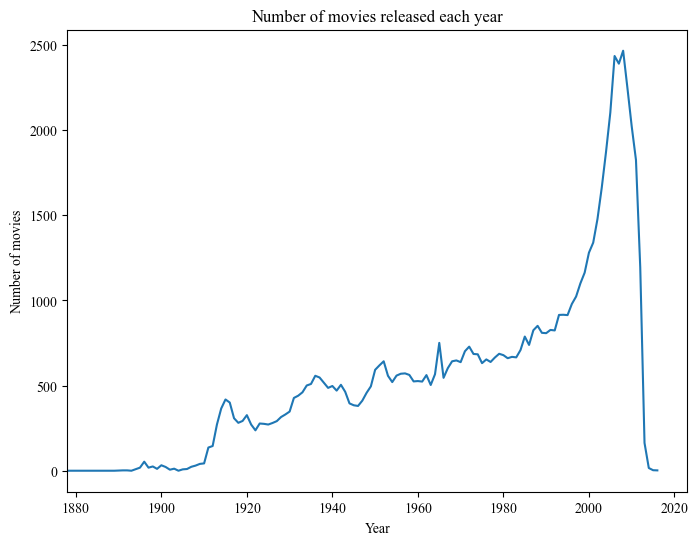

In [6]:
# find the year of the movie
movies['year'] = movies['movie_release_date'].str.extract('(\d{4})', expand=False)
movies['year'] = pd.to_numeric(movies['year'], downcast='integer')

# plot the number of movies released each year
movies_per_year = movies.groupby('year')['movie_name'].count()

plt.figure(figsize=(8, 6))
plt.title('Number of movies released each year')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.xlim(1878, 2023)
plt.plot(movies_per_year)
plt.show()

We first look at the movie release year because movies in different time periods may have different narrative structure and character dynamics. We know that the very first "movie" was produced in 1878 [[1]](https://historycooperative.org/first-movie-ever-made/), so we choose the time range from 1878 to 2023. As we can see, our dataset consists movies from the very early age to the modern times, which provides a solid foundation for us to study and compare the character dynamics over time.

In [ ]:
# average box office revenue per year
movies['movie_box_office_revenue'] = pd.to_numeric(movies['movie_box_office_revenue'], errors='coerce')
mean_revenue_per_year = movies.groupby('year')['movie_box_office_revenue'].mean()
max_revenue_per_year = movies.groupby('year')['movie_box_office_revenue'].max()
revenue_per_year_25 = movies.groupby('year')['movie_box_office_revenue'].quantile(0.05)
revenue_per_year_75 = movies.groupby('year')['movie_box_office_revenue'].quantile(0.95)

# find the name of the two movies with the highest revenue
top1_movie_idx = movies[movies['movie_box_office_revenue'] == max_revenue_per_year.max()].index[0]
top2_movie_idx = movies[movies['movie_box_office_revenue'] == max_revenue_per_year.sort_values(ascending=False).iloc[1]].index[0]


plt.figure(figsize=(10, 6))
plt.title('Box Office Revenue Per Year', fontsize=12)
plt.ylabel('Box Office Revenue (in USD)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.plot(mean_revenue_per_year, color='royalblue', linestyle='-', linewidth=2, label='Average Revenue')
plt.plot(max_revenue_per_year, color='orangered', linestyle='--', linewidth=2, label='Maximum Revenue')

# Shaded area for 5th and 95th percentile
plt.fill_between(mean_revenue_per_year.index, 
                revenue_per_year_25,
                revenue_per_year_75, 
                color='lightblue', alpha=0.3,
                label='Revenue (5th and 95th percentile)')

# Annotate the two movies with the highest revenue
plt.annotate(movies['movie_name'][top1_movie_idx]+' ('+str(int(movies['year'][top1_movie_idx]))+')',
            xy=(movies['year'][top1_movie_idx], movies['movie_box_office_revenue'][top1_movie_idx]),
            xytext=(movies['year'][top1_movie_idx]-5, movies['movie_box_office_revenue'][top1_movie_idx]+1e8),
            fontsize=10)
plt.annotate(movies['movie_name'][top2_movie_idx]+' ('+str(int(movies['year'][top2_movie_idx]))+')',
            xy=(movies['year'][top2_movie_idx], movies['movie_box_office_revenue'][top2_movie_idx]),
            xytext=(movies['year'][top2_movie_idx]-5, movies['movie_box_office_revenue'][top2_movie_idx]+1e8),
            fontsize=10)

# Format y-axis as currency
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()


We will mainly focus on the character dynamics of the plot itself. However, we are still curious about what makes a good story. From this figure, we can see that the average revenue is rather stable across the time (taking inflation into account). But the most successful movies earn significantly more than others. Avatar and Titanic are two most successful movies in history.

We could possibly compare the character dynamics of the most successful movies and the least successful movies to see the difference.

In [ ]:
# average runtime per year
movies['movie_runtime'] = pd.to_numeric(movies['movie_runtime'], errors='coerce')
mean_runtime_per_year = movies.groupby('year')['movie_runtime'].mean()
# drop the outlier
max_mean_runtime_per_year = mean_runtime_per_year.sort_values(ascending=False).iloc[1]
mean_runtime_per_year = mean_runtime_per_year[mean_runtime_per_year < max_mean_runtime_per_year]

outlier_idx = movies[movies['movie_runtime'] == movies['movie_runtime'].max()].index[0]
print('There is an outlier which doesn\'t show in this plot: ',
        movies['movie_name'][outlier_idx], '(',
        str(int(movies['year'][outlier_idx])),
        '), which has a runtime of ',
        movies['movie_runtime'][outlier_idx], 'minutes !')

plt.figure(figsize=(10, 6))
plt.title('Average Runtime Per Year', fontsize=12)
plt.ylabel('Runtime (in minutes)', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)
plt.ylim(40, 140)

plt.plot(mean_runtime_per_year, color='royalblue', linestyle='-', linewidth=2, label='Average Runtime')

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

The movies in early times are usually shorter than nowadays, probably because of the techinical limitations. On the one hand, this could bring differences in movie storytelling. On the other hand, this reminds us that we should be more careful about the network attributes (degrees, density, etc.) when we do further analysis.

In [ ]:
# movie language distribution
query = re.compile(r'"(\w+) Language"')
movies['movie_languages_cleaned'] = movies['movie_languages'].fillna('[]')
movies['movie_languages_cleaned'] = movies['movie_languages'].apply(lambda x: query.findall(x))

movies['movie_languages_num'] = movies['movie_languages_cleaned'].apply(lambda x: len(x) if x != [] else 1)
movie_languages_per_year = {}

for year in range(1920, 2018):
    languages = movies[movies['year'] == year]['movie_languages_cleaned'].sum()
    languages_count = pd.Series(languages).value_counts()
    movie_languages_per_year[year] = languages_count

movie_languages_per_year = pd.DataFrame(movie_languages_per_year).fillna(0).astype(int).transpose()

# plot the top 10 languages
top10_languages = movie_languages_per_year.sum().sort_values(ascending=False).index[:10]
movie_languages_per_year = movie_languages_per_year[top10_languages]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Movie Languages', fontsize=12)
plt.ylabel('Number of movies', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.stackplot(movie_languages_per_year.index,
                movie_languages_per_year.values.T,
                labels=movie_languages_per_year.columns)

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()

Most of the movies are in English. And from the interactive figure below, we can see that a large proportion of movies are produced in America. This adds difficulty for us if we want to analyze the culture differences in character dynamics framing. We need to consider this seriously and make sure the data is reasonably enough for further analysis.

In [ ]:
# country distribution
query = re.compile(r': "(.+)"')
movies['movie_countries_cleaned'] = movies['movie_countries'].fillna('[]')
movies['movie_countries_cleaned'] = movies['movie_countries'].apply(lambda x: query.findall(x)[0] if query.findall(x) != [] else '')

# plot the country distribution per year
country_distribution = movies.groupby(['year', 'movie_countries_cleaned']).size().reset_index(name='count')
country_distribution = country_distribution[country_distribution['year'] >= 1920]
country_distribution['year'] = country_distribution['year'].astype(int)

fig = px.choropleth(
    country_distribution, 
    locations="movie_countries_cleaned", 
    locationmode='country names',
    color="count", 
    hover_name="movie_countries_cleaned",
    animation_frame="year",
    range_color=[0, country_distribution['count'].max()],
    title="Movie Production by Country Over Time"
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
    ),
    width=1000,  # Adjust the width
    height=600   # Adjust the height
)

fig.show()

This interactive image cannot be viewed directly from github.

To see it, first make sure that plotly is installed (pip install plotly) in your local environment, then run the file.

![Map](../generated/images/country_distribution_per_year.png)

In [ ]:
# genre distribution
query = re.compile(r': "(.+?)"')
movies['movie_genres_cleaned'] = movies['movie_genres'].fillna('[]')
movies['movie_genres_cleaned'] = movies['movie_genres'].apply(lambda x: query.findall(x))

movie_genres_per_year = {}
for year in range(1920, 2018):
    genres = movies[movies['year'] == year]['movie_genres_cleaned'].sum()
    genres_count = pd.Series(genres).value_counts()
    movie_genres_per_year[year] = genres_count

movie_genres_per_year = pd.DataFrame(movie_genres_per_year).fillna(0).astype(int).transpose()

# plot the top 10 genres
top10_genres = movie_genres_per_year.sum().sort_values(ascending=False).index[:10]
movie_genres_per_year = movie_genres_per_year[top10_genres]

# change to proportion
movie_genres_per_year = movie_genres_per_year.div(movie_genres_per_year.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
plt.title('Top 10 Movie Genres', fontsize=12)
plt.ylabel('Number of movies', fontsize=10)
plt.xlabel('Year', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(1920, 2017)

plt.stackplot(movie_genres_per_year.index,
                movie_genres_per_year.values.T,
                labels=movie_genres_per_year.columns)

plt.gca().xaxis.grid(False)  # Disable the vertical grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc='upper left', fontsize=10)

plt.show()



# Section II: Character Metadata

Character Metadata encompasses character names and associated details regarding the actors portraying them, such as gender and estimated age during the movie's release.

In [ ]:
characters = pd.read_csv('../data/character.metadata.tsv', sep='\t', header=None)
characters.columns = [
    'wikipedia_movie_id',
    'freebase_movie_id',
    'movie_release_date',
    'character_name',
    'actor_dob',
    'actor_gender',
    'actor_height',
    'actor_ethnicity',
    'actor_name',
    'actor_age',
    'freebase_character_map_1',
    'freebase_character_map_2',
    'freebase_character_map_3'
]
characters.head()

In [ ]:
characters.info()

First, we'll have a look at the missing data here.

In [ ]:
# Calculate missing data ratio for each column
missing_ratio = characters.isnull().mean()

# Display the missing data ratio for each column
print("Missing Data Ratio for Each Column:")
print(missing_ratio)


As we can see from above, several columns have missing data. Notable columns with high missing data ratios include actor_ethnicity (76.47%), character_name (57.22%), actor_height (65.65%), and actor_age (35.08%).Meanwhile, the missing data ratios for some columns are relatively low, such as wikipedia_movie_id, freebase_movie_id, and freebase_character_map_1, which have no missing data.

Then, we shall examine the distribution of estimated character ages (inferred from actors' age in the year when the movie was released with few exceptions) across gender.

In [ ]:
# Drop rows with missing values in 'actor_age' and 'actor_gender' for better visualization
data_for_plot = characters.dropna(subset=['actor_age', 'actor_gender'])

# Create age intervals
age_intervals = pd.cut(data_for_plot['actor_age'], bins=range(0, 100, 5), right=False)

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a countplot for each gender with age intervals of 3
sns.countplot(x=age_intervals, hue='actor_gender', data=data_for_plot, palette='muted', hue_order=['M', 'F'])

# Set labels and title
plt.title('Distribution of Actors by Age Intervals and Gender')
plt.xlabel('Actor Age Intervals')
plt.ylabel('Number of Actors')

# Display the legend
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.show()


As shown from the graph, for characters (actors) whose age is less than 30, there's no significantly more males than females (relatively more females than males in age interval from 15 to 25); but after 30 it's obvious that there are much more males than females.And overall, it still holds true that there are more male characters/actors than female ones. For our further analysis about gender dynamics, this column would remain very useful to us.

Then we'll look at the height of characters/actors.

In [ ]:
# Drop rows with missing values in 'actor_height' and 'actor_gender'
data_for_height_plot = characters.dropna(subset=['actor_height', 'actor_gender']).copy() 

# Convert height to centimeters and create height intervals in centimeters
data_for_height_plot.loc[:, 'actor_height_cm'] = data_for_height_plot['actor_height'] * 100

# Create height intervals in centimeters
data_for_height_plot.loc[:, 'height_intervals'] = pd.cut(data_for_height_plot['actor_height_cm'], bins=range(150, 210, 3), right=False)

# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a countplot for height intervals with gender as hues
sns.countplot(x='height_intervals', hue='actor_gender', data=data_for_height_plot, palette='muted', hue_order=['M', 'F'], dodge=True)

# Set labels and title
plt.title('Distribution of Actor Height by Gender (Intervals of 3 cm)')
plt.xlabel('Actor Height Intervals (in centimeters)')
plt.ylabel('Number of Actors')
plt.xticks(rotation=45)

# Display the legend with specified labels
plt.legend(title='Gender', labels=['Male', 'Female'])

# Show the plot
plt.show()


As we can see, generally speaking, the height of both male and female actors respectively follows the normal distribution with different mean values, which is consistent with common biological difference.

Ethnicity is also an important factor about the actors and characters, though it's not always the same for both. Despite the three-quarters missing data in this column, we try to calculate and list the top 9 ethnicities here.

In [ ]:
# Drop rows with missing values in 'actor_ethnicity' and 'actor_gender'
data_for_ethnicity_plot = characters.dropna(subset=['actor_ethnicity', 'actor_gender'])

# Calculate the percentage distribution of each ethnicity
ethnicity_percentage = data_for_ethnicity_plot['actor_ethnicity'].value_counts(normalize=True) * 100

# Select the top 9 ethnicities
top_9_ethnicities = ethnicity_percentage.head(9)
top_9_ethnicities_series = pd.Series(top_9_ethnicities.values, index=top_9_ethnicities.index, name='Ethnicity Distribution')

# Apply convert_freebase_id_to_entity function to the index of top_10_ethnicities_series
converted_ethnicities = top_9_ethnicities_series.index.map(convert_freebase_id_to_entity)

# Create a new DataFrame with the converted ethnicities and their distribution percentages
top_9_actor_ethnicity = pd.DataFrame({'actor_ethnicity': converted_ethnicities, 'percentage_distribution': top_9_ethnicities_series})

# Display the new DataFrame
print(top_9_actor_ethnicity)

In [ ]:
# Set up the figure and axes
plt.figure(figsize=(8, 8))

# Create a pie chart for the top 10 ethnicities
plt.pie(top_9_actor_ethnicity['percentage_distribution'], labels=top_9_actor_ethnicity['actor_ethnicity'],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('muted'), wedgeprops=dict(width=0.3))

# Set labels and title
plt.title('Top 9 Ethnicities Among Actors and Their Percentage Distribution')

# Show the plot
plt.show()


The top three ethnicities are Indian People, African Americans, and Jews, each contributing significantly to the overall distribution.